In [1]:
from Analysis.analyze import get_predictions_analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import math
from pathlib import Path

d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

def get_results_file(bias_name,templates,bias_types,with_format_few_shot,with_task_few_shot,product=None,cond_value=""):
    if product is not None:
        product = f"{product}/"
    else:
        product = ""
    print(f"{cond_value=}")
    res_file_name = f"Predictions/{bias_name}/{product}logging_aux_{templates}_{bias_types}_{cond_value}format_{with_format_few_shot}_task_{with_task_few_shot}.csv"
    #res_file_name = f"Predictions/{bias_name}/{product}logging_aux_{templates}_{bias_types}_.csv"
    #print(f"{res_file_name=}")
    #display(pd.read_csv(res_file_name))
    return pd.read_csv(res_file_name)
    
def get_decoy_avg(all_products,k_shot,with_format_few_shot=True,with_task_few_shot=False,templates="[1, 2, 3, 4]",bias_types="all",conditions=None) -> pd.DataFrame:
    all_res = []
    if conditions is None or conditions == {None:""}:
        conditions = {"no_cond":[""]}

    print(f"{conditions=}")    
    for cond_name, conds_list in conditions.items():
        print(f"{cond_name=},{conds_list=}")
        for cond_value in list(conds_list):
            print(f"{cond_value=}")
            print(f"{all_products=}")
            for product in all_products:
                try:
                    res = get_results_file("decoy", templates,bias_types,with_format_few_shot,with_task_few_shot,product,cond_value)
                except Exception as e:
                    print(e)
                    continue
                res[f'Product'] = pd.Series([product for x in range(len(res.index))])
                res[f'{cond_name}'] = pd.Series([cond_value for x in range(len(res.index))])
                #print("-"*20)
                #display(res)
                all_res.append(res)
    all_res = pd.concat(all_res)

    if k_shot != -1:
        all_res = all_res[all_res["k_shot"]==k_shot]

    return all_res

def get_biases_info(bias_name):
    if bias_name == "decoy":
        templates =  "[1, 2, 3, 4]"
        bias_types = "all"
        cols_to_eval = ["bias_score","p_value","Treatment Option 1 Percentage", "Control Option 1 Percentage","Treatment Option 2 Percentage", "Control Option 2 Percentage","Treatment Option 3 Percentage", "Control Option 3 Percentage"]#,"Undecided Bias Decoy", "Undecided No Decoy"]
    elif bias_name == "certainty":
        templates = "[1, 2, 3]"
        #bias_types = "three_probs,two_probs"
        bias_types = "three_probs,two_probs,not_probable_long"
        cols_to_eval = ["bias_score","p_value","Treatment Option 1 Percentage", "Control Option 1 Percentage","Treatment Option 2 Percentage", "Control Option 2 Percentage","Treatment Option 3 Percentage", "Control Option 3 Percentage"]
    elif bias_name == "false_belief":
        bias_types = "dm_full"
        templates = "[1, 2, 3, 4, 5, 6, 7]"
        cols_to_eval = ["Belief Valid", "Belief Invalid","Treatment Option 1 Percentage", "Control Option 1 Percentage","Treatment Option 2 Percentage", "Control Option 2 Percentage","Treatment Option 3 Percentage", "Control Option 3 Percentage"]
    else:
        raise ValueError("bias_name must be one of: decoy, certainty, false_belief")
    
    return templates, bias_types, cols_to_eval

In [3]:
translation_dict = {"flan-t5-xl":"Flan-T5-XL","flan-t5-xxl":"Flan-T5-XXL","flan-t5-small":"Flan-T5-Small","flan-t5-base":"Flan-T5-Base","flan-t5-large":"Flan-T5-Large",
                    "davinci":"DaVinci","text-davinci-002":"DaVinci-002","text-davinci-003":"DaVinci-003","gpt-4-0314":"GPT4",
                    "t5-v1_1-xl":"T5-XL","t5-v1_1-xxl":"T5-XXL","t5-v1_1-small":"T5-Small","t5-v1_1-base":"T5-Base","t5-v1_1-large":"T5-Large",
                    "property":"Real-Estate","phone":"Phone", "car":"Car", "frying_pan":"Frying Pan",
                    "property_cheaper":"Real-Estate","phone_cheaper":"Phone", "car_cheaper":"Car", "frying_pan_cheaper":"Frying Pan",
                    "[price1_$80K,_price2_$80K]":"$80K","[price1_$90K,_price2_$90K]":"$90K","[price1_$100K,_price2_$100K]":"$100K","[price1_$110K,_price2_$110K]":"$110K",
                    "three_probs":"Three Parts","two_probs":"Two Parts","not_probable":"Not Probable",
                    "R_EXTREAM":"R*",
                    #"Decoy Expensive":"Decoy\nExpensive","Decoy Cheaper":"Decoy\nCheaper", "Belief Valid":"Belief\nValid", "Belief Invalid":"Belief\nInvalid",
                    }
map_prize_to_utility = {
    '2400':9,
    '2500':145,
    '2600':289,
    '800':32,
    '850':29,
    '1300':37,
    '4800':2,
    '3000':200,
    '4000':250,
    '5000':100,
    '2000':100,
    '1000':200,
}
products_order = ["Frying Pan","Phone","Car","Real-Estate"]

cond_name=None, cond_value=''
cond_value=''


,model,Real Accuracy,Non-Real Accuracy,k_shot,normalize,Belief Valid,Belief Invalid,Treatment Option 1 Percentage,Control Option 1 Percentage,Treatment Option 2 Percentage,Control Option 2 Percentage,Treatment Option 3 Percentage,Control Option 3 Percentage,Bias,Bias Score
0,DaVinci,0.524,0.504,0,True,0.00,0.04,0.74,0.74,0.26,0.26,0.0,0.0,Belief Valid,0.00
1,DaVinci-002,0.582,0.647,0,False,0.19,0.55,0.36,0.50,0.64,0.50,0.0,0.0,Belief Valid,0.19
2,DaVinci-003,0.615,0.726,0,False,0.21,0.65,0.34,0.40,0.65,0.57,0.0,0.0,Belief Valid,0.21


cond_name=None, cond_value=''
cond_value=''


,model,Real Accuracy,Non-Real Accuracy,k_shot,normalize,Belief Valid,Belief Invalid,Treatment Option 1 Percentage,Control Option 1 Percentage,Treatment Option 2 Percentage,Control Option 2 Percentage,Treatment Option 3 Percentage,Control Option 3 Percentage,Bias,Bias Score
0,DaVinci,0.524,0.504,0,True,0.00,0.04,0.74,0.74,0.26,0.26,0.0,0.0,Belief Invalid,0.04
1,DaVinci-002,0.582,0.647,0,False,0.19,0.55,0.36,0.50,0.64,0.50,0.0,0.0,Belief Invalid,0.55
2,DaVinci-003,0.615,0.726,0,False,0.21,0.65,0.34,0.40,0.65,0.57,0.0,0.0,Belief Invalid,0.65


,Model,Real Accuracy,Non-Real Accuracy,K-shot,Normalize,Belief Valid,Belief Invalid,Treatment Option 1 Percentage,Control Option 1 Percentage,Treatment Option 2 Percentage,Control Option 2 Percentage,Treatment Option 3 Percentage,Control Option 3 Percentage,Bias,Bias Score,Few Shot Type,Accuracy
0,DaVinci,0.524,0.504,0,True,0.00,0.04,0.74,0.74,0.26,0.26,0.0,0.0,Belief Valid,0.00,Format,0.5140
1,DaVinci-002,0.582,0.647,0,False,0.19,0.55,0.36,0.50,0.64,0.50,0.0,0.0,Belief Valid,0.19,Format,0.6145
2,DaVinci-003,0.615,0.726,0,False,0.21,0.65,0.34,0.40,0.65,0.57,0.0,0.0,Belief Valid,0.21,Format,0.6705
0,DaVinci,0.524,0.504,0,True,0.00,0.04,0.74,0.74,0.26,0.26,0.0,0.0,Belief Invalid,0.04,Format,0.5140
1,DaVinci-002,0.582,0.647,0,False,0.19,0.55,0.36,0.50,0.64,0.50,0.0,0.0,Belief Invalid,0.55,Format,0.6145
2,DaVinci-003,0.615,0.726,0,False,0.21,0.65,0.34,0.40,0.65,0.57,0.0,0.0,Belief Invalid,0.65,Format,0.6705


d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

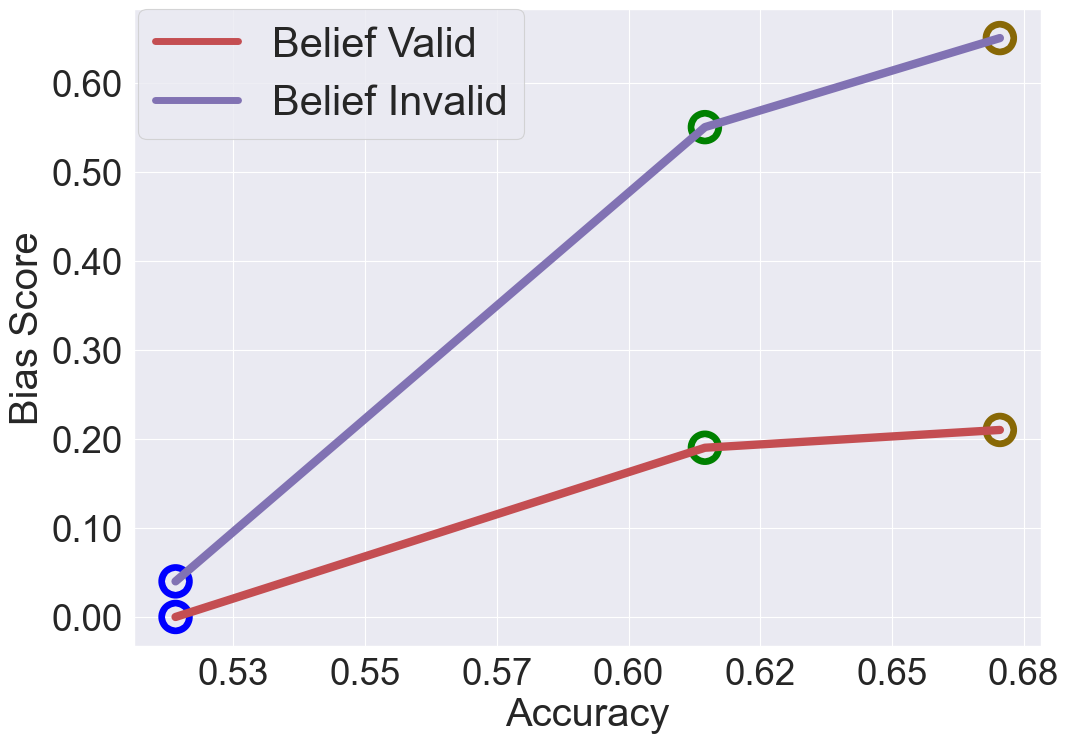

In [52]:

def get_results_avg(bias_name,models,all_products,k_shot,with_format_few_shot,with_task_few_shot,should_reset_index,group_by,conditions):
    templates, bias_types, cols_to_eval = get_biases_info(bias_name)

    if bias_name == "decoy":
        res = get_decoy_avg(all_products,k_shot,with_format_few_shot,with_task_few_shot,templates,bias_types,conditions)
    else:
        all_res = []
        #print(f"{conditions=}")
        if conditions is not None:
            for cond_name, conds_list in conditions.items():
                for cond_value in list(conds_list):
                    print(f"{cond_name=}, {cond_value=}")
                    # if bias_name == "certainty" and cond_value == "":
                    #     bias_types += "_bias_types_1_2"
                    res = get_results_file(bias_name,templates,bias_types,with_format_few_shot,with_task_few_shot,cond_value=cond_value)
                    res[f'{cond_name}'] = pd.Series([cond_value for x in range(len(res.index))])
                    all_res.append(res)
            res = pd.concat(all_res)
        else:
           res = get_results_file(bias_name,templates,bias_types,with_format_few_shot,with_task_few_shot)

    #print(f"res=")
    #print("2"*80)
    #display(res)
    # take only rows with k_shot
    if k_shot != -1:
        res = res[res["k_shot"]==k_shot]
    #print("3"*80)
    #print(f"{group_by=}")
    #display(res)
    res = res[res["model"].isin(models)]
    res_gb = res.groupby(group_by, as_index=not should_reset_index)[cols_to_eval]
    #print("after groupby")
    #print("4"*80)
    #display(res_gb)
    res_gb = res_gb.mean()
    #print("5"*80)
    #display(res_gb)
    return res_gb


def get_results_for_all_biases(all_biases,all_models,k_shot,should_reset_index,belief_format_shot,all_products={"Decoy Expensive":"all","Decoy Cheaper":"all"},group_by=["model","k_shot","normalize"],decoy_group_by=["model","k_shot","normalize"],belief_group_by=None,conditions=None):
    whole_res = []
    with_task_few_shot = False
    for bias_name in all_biases:
        cur_products = ""
        if "Decoy" in bias_name:
            cur_group_by = decoy_group_by
            with_format_few_shot = True#False
        elif "Belief" in bias_name:
            if belief_group_by is not None:
                cur_group_by = belief_group_by
            else:
                cur_group_by = group_by
            if belief_format_shot:
                with_format_few_shot = True
                with_task_few_shot = False
            else:
                with_format_few_shot = False
                with_task_few_shot = True
        else:
            cur_group_by = group_by
            with_format_few_shot = True

        if bias_name == "Decoy Expensive":
            cur_bias_name = "decoy"
            if all_products["Decoy Expensive"] == "all":
                cur_products = ["frying_pan","phone", "car","property" ]
            else:
                cur_products = all_products["Decoy Expensive"]
            bias_score = "bias_score"
        elif bias_name == "Decoy Cheaper":
            cur_bias_name = "decoy"
            if all_products["Decoy Cheaper"] == "all":
                cur_products = ["frying_pan_cheaper","phone_cheaper", "car_cheaper","property_cheaper"]
            else:
                cur_products = all_products["Decoy Cheaper"]
            bias_score = "bias_score"
        elif bias_name == "Certainty":
            cur_bias_name = "certainty"
            bias_score = "bias_score"
        elif bias_name == "Belief Valid":
            cur_bias_name = "false_belief"
            bias_score = "Belief Valid"
        elif bias_name == "Belief Invalid":
            cur_bias_name = "false_belief"
            bias_score = "Belief Invalid"
        else:
            raise ValueError("bias_name must be one of: Decoy Expensive, Decoy Cheaper, Certainty, Belief Valid, Belief Invalid")
        
        res_avg = get_results_avg(cur_bias_name,all_models,cur_products,k_shot,with_format_few_shot,with_task_few_shot,should_reset_index,cur_group_by,conditions) # type: ignore
        #print("7"*80)
        #display(res_avg)
        res_avg["Bias"] = bias_name
        res_avg["Bias Score"] = res_avg[bias_score]
        #print(f"{bias_name=}")
        #print("1"*80)
        #print("X"*80)
        display(res_avg)
        if "Belief" in bias_name:
            res_avg["Few Shot Type"] = "Task" if with_format_few_shot else "Format" # opposite for lagcy predictions
        else:
            res_avg["Few Shot Type"] = "Task" if with_task_few_shot else "Format" # opposite for lagcy predictions
        whole_res.append(res_avg)
    whole_res = pd.concat(whole_res)
    if not should_reset_index:
        whole_res = whole_res.reset_index()
    whole_res = whole_res.rename(columns={"model":"Model","Product":"Product","k_shot":"K-shot","normalize":"Normalize","p_value":"P-value","Size":"Size","Bias":"Bias"})
    whole_res = whole_res.replace(translation_dict)
    if 'bias_score' in whole_res.columns:
        whole_res.drop('bias_score', axis=1)
    return whole_res


def get_figure(figure_name,whole_res,x_axis,plot_type,hue):
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    #sns.set(font_scale=3)
    sns.set(font_scale=2.5) # model_size bar plot
    # set x ticks to [0,1,2,3]
    if x_axis != "Accuracy":
        plt.xticks(np.arange(0, 4, 1))

    #sns.set_style("ticks")
    #sns.set(style='dark',)
    sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 5})
    #sns.set_palette("colorblind")
    #sns.set_palette("Set2")
    #sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
    #sns.lineplot(data=whole_res, x="Model", y="Bias Score", hue="Bias", style="Product", markers=True, dashes=False, err_style="bars", ci=95, legend="full")
    # color palette as dictionary
    # take colors 2 and 3 from the palette, and reverse the order
    #bar_palette =  sns.color_palette()[8:10]#[::-1]#[2:10]#[::-1] # model size bar plot
    bar_palette =  sns.color_palette()[4:11]#[::-1]#[2:10]#[::-1] # model size bar plot
    line_palette =  sns.color_palette()[3:10]#[::-1]#[2:10]#[::-1] # acc vs bias belief
    #line_palette =  sns.color_palette() # format few-shot
    #line_palette =  sns.color_palette()[1:10] # task few-shot
    # {"Adelie":"tab:cyan",
    #         "Gentoo":"tab:orange", 
    #         "Chinstrap":"tab:purple"}
    if plot_type == "bar":
        sns.barplot(data=whole_res, x=x_axis, y="Bias Score", hue=hue, errorbar=('ci', 95), palette=bar_palette, errwidth=3, edgecolor="black")
    else:
        # sns.lineplot(
        #     data=whole_res,x=x_axis, y="Bias Score", hue=hue, markers=True, dashes=False, palette=line_palette, err_style="band", legend="full", linewidth=6,sort=False)
        # line plot with a dot for each point
        sns.lineplot(
            data=whole_res,x=x_axis, y="Bias Score", hue=hue, markers=True, dashes=False, palette=line_palette, err_style="bars", legend="full", linewidth=6,sort=False)
        if x_axis == "Accuracy": # marking the models in the accuracy vs. bias in belief analysis
            sns.scatterplot(data=whole_res, x=x_axis, y="Bias Score",hue=hue, legend=False, linewidth=20, edgecolor=['blue','green',sns.xkcd_rgb['muddy brown']])

    plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
    if x_axis == "Accuracy":
        plt.gca().xaxis.set_major_formatter('{:.2f}'.format)
    #plt.legend(bbox_to_anchor=(0.53, 1.00), borderaxespad=0,fontsize=30)
    #plt.legend(bbox_to_anchor=(1.10, 1.80), borderaxespad=0,fontsize=30) # k_shot
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=30)
    plt.legend(bbox_to_anchor=(0.43, 1.00), borderaxespad=0,fontsize=30) # model_size + product bar plot
    #plt.legend(bbox_to_anchor=(0.38, 0.90), borderaxespad=0,fontsize=25) # format few-shot
    #plt.legend(bbox_to_anchor=(0.25, 0.80), borderaxespad=0,fontsize=25) # task few-shot
    #plt.tight_layout()

    
    
    plt.savefig(figure_name, bbox_inches='tight')

    return whole_res



# Models parameters

#models = "davinci,text-davinci-002,text-davinci-003,gpt-4-0314,t5-v1_1-xl,flan-t5-xl,t5-v1_1-xxl,flan-t5-xxl".split(',')
#models = "davinci,text-davinci-002,text-davinci-003,t5-v1_1-xxl,flan-t5-xxl".split(',')
#models = "t5-v1_1-xxl,flan-t5-xxl".split(',')
models = "davinci,text-davinci-002,text-davinci-003".split(',')
#models = "flan-t5-xl,flan-t5-xxl".split(',')
#models = "text-davinci-003,flan-t5-xxl".split(',')
#models = "flan-t5-xxl".split(',')
#models = "text-davinci-003".split(',')
#models = "flan-t5-xxl".split(',')
#models = "t5-v1_1-xxl".split(',')
#models = "t5-v1_1-small,flan-t5-small".split(',')

# add to models the tranlated names
models += [translation_dict[model] for model in models]

figure_name = f"Figures/testing.pdf"#f"Figures/testing_{models}.pdf"
k_shot = -1 # -1 for all
x_axis = "Accuracy"#"Product"#"Bias"##"Model"###"Bias Type" #"Model"#"K-shot"#"Model"###"Price"#####"Model"# #"Prize"# # #  #
certainty_convert_prize_to_utility_gap = False
print_options_percentages = False
print_products_table = False
plot_type = "line"#"bar"
hue = "Bias"#"Model"
#all_biases = ["Decoy Expensive","Decoy Cheaper","Certainty","Belief Valid","Belief Invalid"]
#all_biases = ["Decoy Cheaper","Decoy Expensive"]
#all_biases = ["Decoy Cheaper"]
#all_biases = ["Decoy Expensive"]
all_biases = ["Belief Valid","Belief Invalid"]
#all_biases = ["Certainty"]

# Biases parameters

should_reset_index = True # False mainly for decoy product analysis
all_products = {"Decoy Expensive":"all","Decoy Cheaper":"all"}#{"Decoy Expensive":["property"],"Decoy Cheaper":["property_cheaper"]}
decoy_group_by = ["model","Product","k_shot","normalize"]#["model","k_shot","normalize"]# #["model","Bias Type","k_shot","normalize"]#["model","Price","k_shot","normalize"]
#conditions_lists = {"Price":["[price1_$80K,_price2_$80K]","[price1_$90K,_price2_$90K]","[price1_$100K,_price2_$100K]","[price1_$110K,_price2_$110K]"]}#{"Bias Type":["three_probs","two_prob","not_probable"]}#None #[price1_$80K,_price2_$80K]
#conditions_lists = {"Bias Type":["R","RF","F","R_EXTREAM"]}
#conditions_lists = {"Bias Type":["three_probs","two_probs","not_probable"]}
#conditions_lists = {"Prize":["800", "850", "1300", "2400", "2500", "2600", "4800","1000_two_probs","2000_two_probs","3000_two_probs","4000_two_probs","5000_two_probs"]}
#conditions_lists = {"Prize":["1300", "2400", "2500", "2600","1000_two_probs","2000_two_probs","3000_two_probs","4000_two_probs"]}
conditions_lists = {None:[""]}
belief_group_by = ["model", "Real Accuracy", "Non-Real Accuracy", "k_shot","normalize"]#["model", "k_shot","normalize"]#["model", "k_shot","normalize", "Few Shot Type"] 
group_by = ["model","k_shot","normalize"]#["model", "Prize","k_shot","normalize"]#
normlize = None # None is for nothing
all_belief_format_shot = [False]#[True,False]# # True is for technical format few shot

if len(all_belief_format_shot) > 1:
    whole_res = []
    for belief_format_shot in all_belief_format_shot:
        whole_res.append(get_results_for_all_biases(all_biases,models,k_shot,should_reset_index,belief_format_shot,all_products,group_by,decoy_group_by,belief_group_by))
    whole_res = pd.concat(whole_res)
    # print("8"*80)
    # display(whole_res)
    hue = "Few Shot Type"
    #hue = whole_res[['Few Shot Type','Bias']].apply(tuple, axis=1)
    hue = whole_res[['Few Shot Type','Bias']].apply(lambda x: f"{x['Few Shot Type']} - {x['Bias']}", axis=1)
else:
    whole_res = get_results_for_all_biases(all_biases,models,k_shot,should_reset_index,all_belief_format_shot[0],all_products,group_by,decoy_group_by,belief_group_by,conditions_lists)
#whole_res.sort_values(by='Product', key=lambda col: sorted(col, key=lambda p: products_order.index(p)))
if "Price" in whole_res.columns or "Prize" in whole_res.columns:
    if "Price" in whole_res.columns:
        whole_res["price_int"] = whole_res["Price"].str.replace('$', '').str.replace('K', '').astype(float)
    else:
        whole_res["price_int"] = whole_res["Prize"].str.extract(r'(\d+)', expand=False).astype(int)#.str.replace('$', '').str.replace('K', '').astype(float)
        whole_res["Prize"] = whole_res["Prize"].apply(lambda x: x.replace("_two_probs",""))
        if certainty_convert_prize_to_utility_gap:
            whole_res["Utility Gap"] = whole_res["Prize"].apply(lambda x: map_prize_to_utility[x])
            whole_res["Prize"] = whole_res["Utility Gap"]
            whole_res["price_int"] = whole_res["Utility Gap"]
            x_axis = "Utility Gap"
    whole_res.sort_values(by='price_int', inplace=True)
    whole_res.drop(columns=["price_int"], inplace=True)

# drop rows according to normlize
if normlize is not None:
    print("Filtering by normlize")
    whole_res = whole_res[(((whole_res["Model"].isin(['DaVinci','T5-XL','T5-XXL'])) & (whole_res["Normalize"] == normlize))
                          | (whole_res["Model"].isin(['DaVinci-002','DaVinci-003','Flan-T5-XL','Flan-T5-XXL'])))]
    whole_res.drop(columns=["Normalize"], inplace=True)

if x_axis == "Accuracy":
    whole_res['Accuracy'] = whole_res[['Real Accuracy', 'Non-Real Accuracy']].mean(axis=1)

if print_options_percentages:
    display(whole_res)
    print(whole_res[['Model', 'Normalize','Bias' ,'Control Option 1 Percentage','Control Option 2 Percentage','Control Option 1 Percentage','Control Option 2 Percentage','Treatment Option 1 Percentage','Treatment Option 2 Percentage','Treatment Option 3 Percentage']].to_latex(index=False,
                    float_format="{:.1%}".format,
                    na_rep="",
    ))
elif print_products_table:
    whole_res.sort_values(by='Product', inplace=True)
    #whole_res.sort_values(by='Bias', inplace=True)
    print(whole_res[['Model','Bias' ,'Product', 'Bias Score', 'P-value']].to_latex(index=False,
                    float_format="{:.2f}".format,
                    na_rep="",
    ))
else:
    display(whole_res)
try:
    get_figure(figure_name,whole_res,x_axis,plot_type,hue)
except Exception as e:
    print(e)
    print("Failed to save figure")
    pass

### Figure 1

d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\School\Projects\Technical\envs\insttobias\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

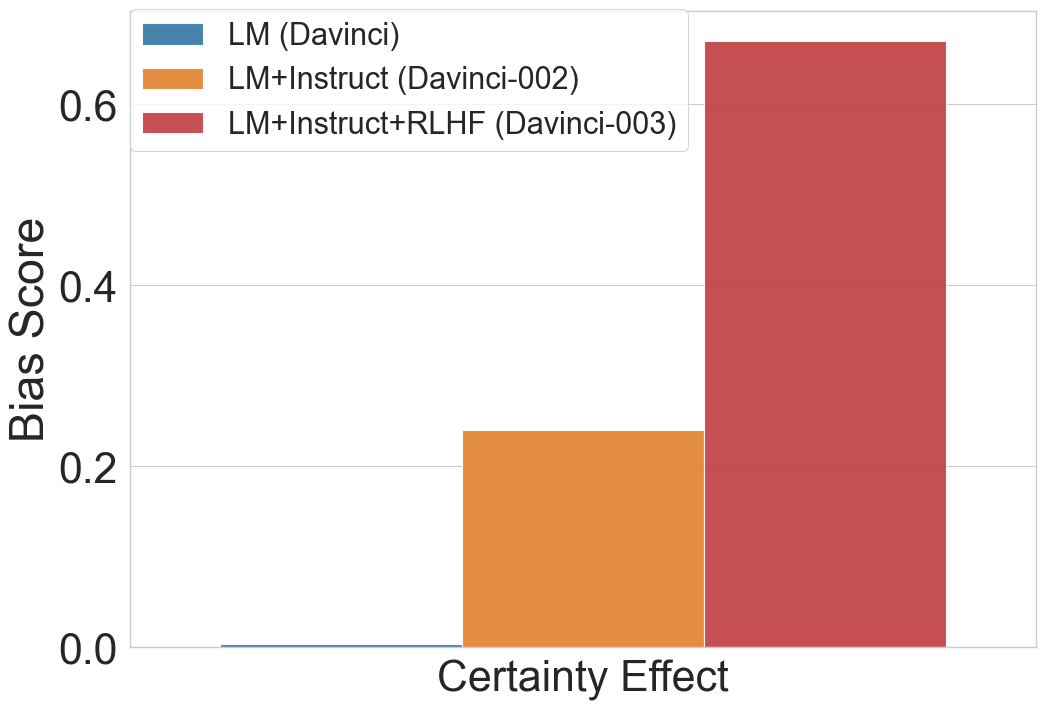

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

final_result = [-0.15,-0.17,0.004,-0.03,0.09,   -0.13,-0.08,0.24,0.18,0.55    ,-0.02,0.08,0.67,0.23,0.61]
plot_df = pd.DataFrame({"Model": ["LM (Davinci)"]*5+["LM+Instruct (Davinci-002)"]*5+["LM+Instruct+RLHF (Davinci-003)"]*5, "Bias Type": ["Decoy Expensive", "Decoy Cheaper","Certainty Effect","Belief Valid","Belief Invalid"]*3, "Bias Score":final_result })
plot_df = plot_df[plot_df["Bias Type"] == "Certainty Effect"]


sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(9.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=3.5)
#sns.set_context("paper", font_scale=3)
sns.set_palette("dark")

colors = ["tab:blue", "tab:orange", "tab:red"]
out = sns.barplot(
    x="Bias Type",
    y="Bias Score",
    hue="Model",
    data=plot_df,
    alpha=0.9,
    palette=colors,
)
plt.xlabel("")
plt.ylabel("Bias Score")
#plt.ylim(-0.001, 0.7)
# plt.title(f"{plot_name} {model}")
#plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right", borderaxespad=1)
plt.legend(bbox_to_anchor=(0.65, 1.05), loc="upper right", borderaxespad=1, fontsize=22)
#plt.legend(bbox_to_anchor=(0.655, 1.04), loc="upper right", borderaxespad=1, fontsize=19)
#plt.tight_layout()
plt.savefig("Figures/figure_1.pdf", bbox_inches='tight')
#plt.savefig("Figures/figure_1_testing.pdf")